# Homework, CBRP Model

In [38]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
from torchvision.models import resnet18

from PIL import Image

import os
dp = os.environ.get('DATA_PATH')
data = dp + 'AI_Cheats/dataset_cv23/'

In [39]:
# Define the format of the read file
def default_loader(path):
    return Image.open(path).convert('RGB')

In [40]:
# Create your own class: MyDataset, inheriting from the Dataset class
class MyDataset(Dataset):
    def __init__(self, txt, data_path=None, transforms=None, target_transform=None, loader=default_loader):
        super(MyDataset, self).__init__() # Initialize the attributes inherited from the parent class
        # In the __init__() method, obtain the image paths and form an array of image paths
        file_path = data_path + txt
        file = open(file_path, 'r')
        imgs = []
        for line in file:
            line = line.split()
            # print(line[0].rstrip(',')) # img
            # print(line[1].rstrip('\n)) # label
            # 11111.jpg, 8
            # 22222.jpg, 9

            imgs.append((line[0].rstrip(','), line[1].rstrip('\n')))
        self.imgs = imgs
        self.transform = transforms
        self.target_transform = target_transform
        self.loader = loader
        self.data_path = data_path

    def __getitem__(self, index):
        # Read the specific content of each element by index
        imgName, label = self.imgs[index]        
        imgPath = self.data_path + imgName
        # print(f'Loading images: {imgPath}')
        try:
            img = self.loader(imgPath)
        except Exception as e:
            print(f'Error loading image {imgPath}: {e}')
        if self.transform is not None:
            img = self.transform(img) # Convert data label to Tensor
            label = torch.from_numpy(np.array(int(label)))
        return img, label

    def __len__(self):
        # Return the number of images in the dataset
        return len(self.imgs)

In [41]:
print(resnet18())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            resnet18().conv1,
            resnet18().bn1,
            resnet18().relu,
            resnet18().maxpool,
            resnet18().layer1,
            resnet18().layer2,
            resnet18().layer3,
            resnet18().layer4
        )
        self.classifiers = nn.Sequential(nn.Linear(512**2, 14))

    def forward(self, x):
        x = self.features(x)
        batch_size = x.size(0)
        # 512, m, m -> 512, m^2
        x = x.view(batch_size, 512, x.size(2) **2)
        # 512, m^2 -> m^2, 512
        x = (torch.bmm(x, torch.transpose(x, 1, 2)) / (x.size(2) **2)).view(batch_size, -1)
        x = torch.nn.functional.normalize(torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10))
        x = self.classifiers(x)
        return x

![](https://pic4.zhimg.com/80/v2-67c1b41dff89e3f5b620a16d2440e2f7_1440w.jpg)

In [43]:
my_resnet = Net()
print(my_resnet)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [44]:
# Preprocessing settings
# Resize images to the size required by ResNet
# Normalization by subtracting the mean and dividing by the standard deviation
# Convert numpy array to tensor format
train_tf = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.557, 0.517, 0.496], [0.210, 0.216, 0.222])
])
'''
normMean = [0.55671153 0.51730426 0.4980584]
normStd = [0.21057842 0.21577705 0.222336]
'''

test_tf = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize([0.557, 0.517, 0.496], [0.210, 0.216, 0.222])
])

# Dataset loading settings
train_data = MyDataset(txt='train_set_0.txt', data_path=data, transforms=train_tf)
test_data = MyDataset(txt='test_set_0.txt', data_path=data, transforms=test_tf)

# Using DataLoader to load datasets
train_loader = DataLoader(dataset=train_data, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False, num_workers=0)


In [45]:
# my_resnet = Net()

# Hyperparameter settings
learn_rate = 0.0001
num_epoches = 70
# Multi-class loss function, using default values
criterion = nn.CrossEntropyLoss()
# Gradient descent, optimizing the parameters of the last layer of the model
# optimizer = optim.SGD(my_resnet.parameters(), lr=learn_rate, momentum=0.9)
optimizer = optim.Adam(my_resnet.parameters(), lr=learn_rate, betas=(0.9, 0.99))
# Learning rate adjustment
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True, threshold=1e-4)

# Determine whether to use CPU or GPU
device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu')

# Training phase
my_resnet.to(device)
my_resnet.train()

for epoch in range(num_epoches):
    print(f'epoch: {epoch+1}')
    for idx, (img, label) in enumerate(train_loader):
        # print(f'Batch index: {idx}') # print index
        images = img.to(device) 
        labels = label.to(device)
        try:
            output = my_resnet(images)
            loss = criterion(output, labels)
            loss.backward() # Backpropagate the loss
            optimizer.step() # Update the gradients
            # scheduler.step()
            optimizer.zero_grad() # Clear the gradients
        except Exception as e:
            print(f'Error at batch {idx}: {e}') # except error
        if idx % 100 == 0:
            print(f'current loss = {loss.item()}')

epoch: 1
current loss = 2.6389200687408447
epoch: 2
current loss = 2.682981014251709
epoch: 3
current loss = 2.173555612564087
epoch: 4
current loss = 2.1134603023529053
epoch: 5
current loss = 2.0477402210235596
epoch: 6
current loss = 2.0832631587982178
epoch: 7
current loss = 1.5229636430740356
epoch: 8
current loss = 1.712094783782959
epoch: 9
current loss = 1.640045166015625
epoch: 10
current loss = 1.8980720043182373
epoch: 11
current loss = 1.4385297298431396
epoch: 12
current loss = 1.2610132694244385
epoch: 13
current loss = 1.2373353242874146
epoch: 14
current loss = 1.450379729270935
epoch: 15
current loss = 1.9530290365219116
epoch: 16
current loss = 1.4619135856628418
epoch: 17
current loss = 1.196214199066162
epoch: 18
current loss = 1.1256728172302246
epoch: 19
current loss = 0.7199023365974426
epoch: 20
current loss = 1.2663886547088623
epoch: 21
current loss = 0.5469716787338257
epoch: 22
current loss = 0.836722731590271
epoch: 23
current loss = 0.37503162026405334
epo

In [46]:
# Testing phase
my_resnet.to(device)
my_resnet.eval() # Freeze the parameters of the trained model
total, correct = 0, 0
for img, label in test_loader:
    images = img.to(device)
    labels = label.to(device)
    # print('label:', labels)
    output = my_resnet(images)
    # print('output:', output.data.size)
    _, idx = torch.max(output.data, 1) # Get the position of the maximum value
    # print('idx:', idx)
    total += labels.size(0) # Total number of images
    correct += (idx == labels).sum() # Number of correct images
    # print('correct_num: %f', correct)

print('correct_num: ', correct)
print('total_image_num: ', total)
print(f'accuacy: {100.*correct/total}')

correct_num:  tensor(23)
total_image_num:  30
accuacy: 76.66666412353516


In [47]:
model_name = 'Bilinear_resnet_model.pkl'
save_path = data + 'content/' + model_name
torch.save(my_resnet, save_path)

In [48]:
label_idx = dict({'农夫山泉': 0, '冰露': 1, '娃哈哈': 2,
                  '可口可乐': 3, '天府可乐': 4, '其它': 5,
                  '康师傅': 6, '百事可乐': 7, '怡宝': 8,
                  '百岁山': 9, '苏打水': 10, '景甜': 11,
                  '恒大冰泉': 12, '今麦郎': 13}
)

idx_label = dict({'0': '农夫山泉', '1': '冰露', '2': '娃哈哈', 
                 '3': '可口可乐', '4': '天府可乐', '5': '其它', 
                 '6': '康师傅', '7': '百事可乐', '8': '怡宝', 
                 '9': '百岁山', '10': '苏打水', '11': '景甜', 
                 '12': '恒大冰泉', '13': '今麦郎'})

label: 5
idx:  5
预测标签名称:  其它


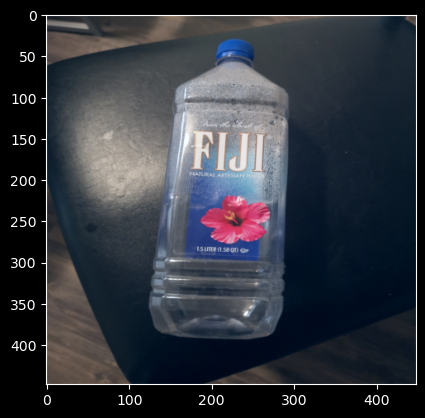

label: 8
idx:  8
预测标签名称:  怡宝


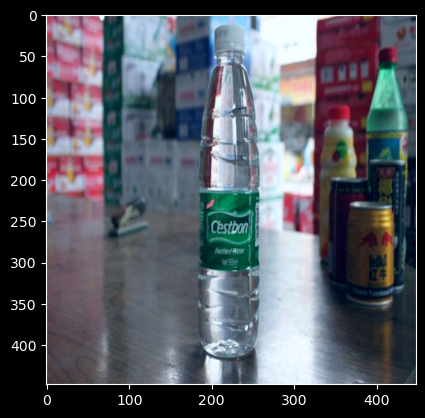

label: 8
idx:  8
预测标签名称:  怡宝


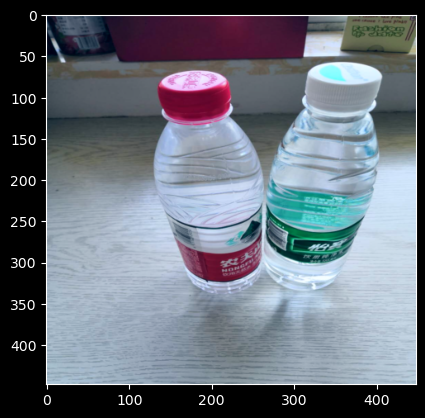

label: 9
idx:  9
预测标签名称:  百岁山


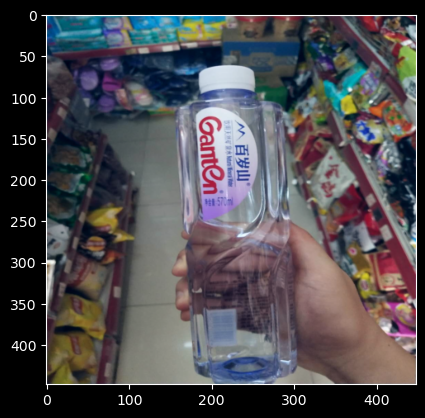

label: 2
idx:  2
预测标签名称:  娃哈哈


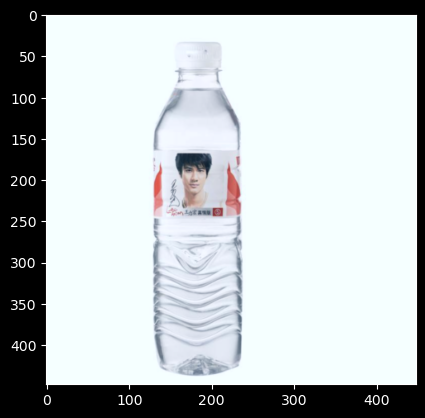

label: 8
idx:  8
预测标签名称:  怡宝


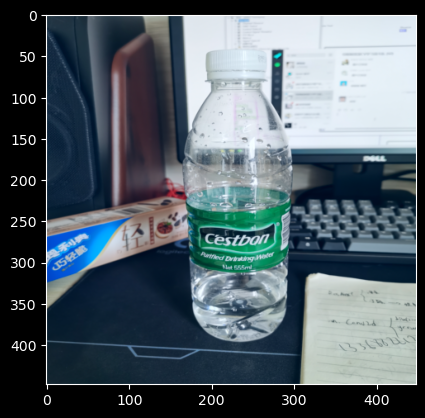

label: 4
idx:  4
预测标签名称:  天府可乐


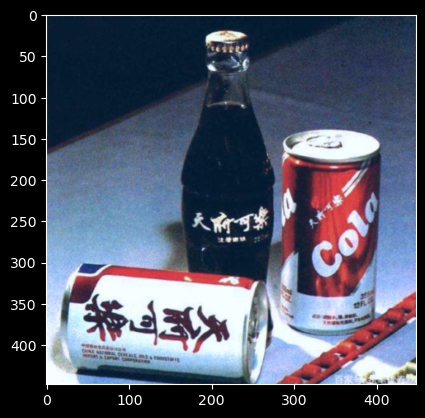

label: 2
idx:  2
预测标签名称:  娃哈哈


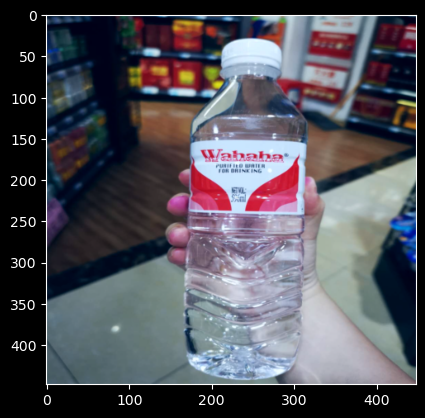

label: 12
idx:  12
预测标签名称:  恒大冰泉


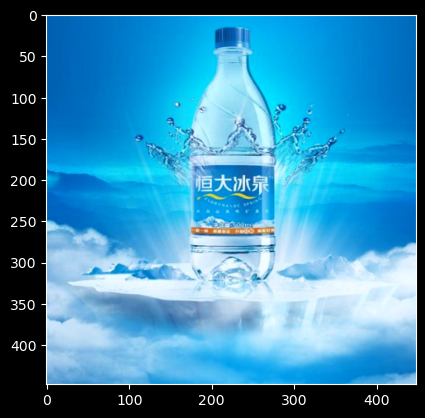

label: 1
idx:  5
预测标签名称:  其它


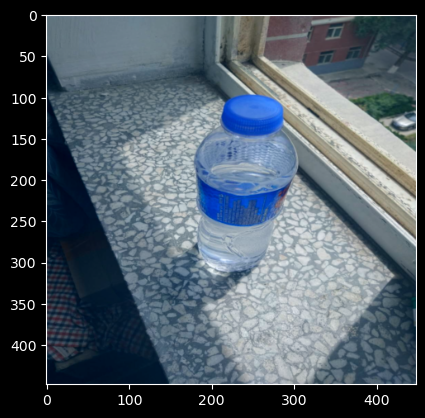

label: 8
idx:  8
预测标签名称:  怡宝


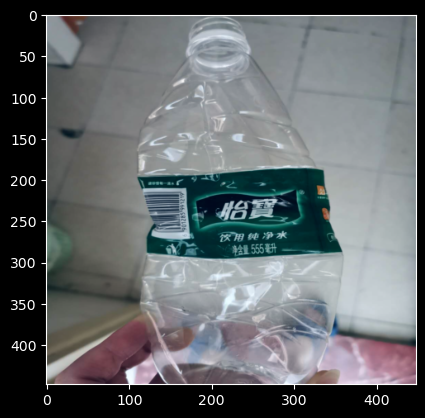

label: 0
idx:  0
预测标签名称:  农夫山泉


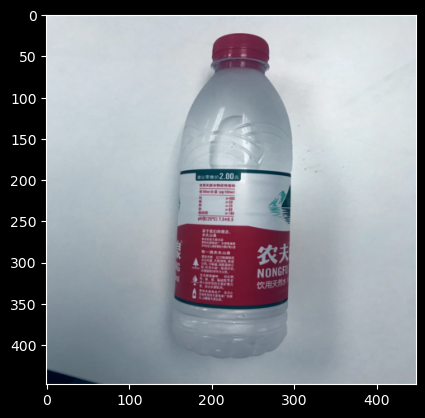

label: 1
idx:  5
预测标签名称:  其它


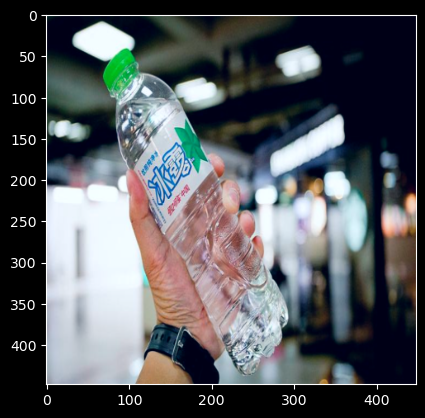

label: 0
idx:  0
预测标签名称:  农夫山泉


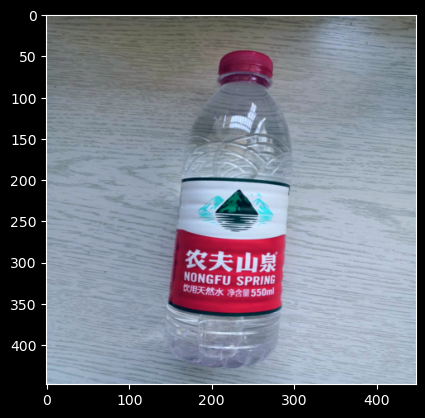

label: 2
idx:  1
预测标签名称:  冰露


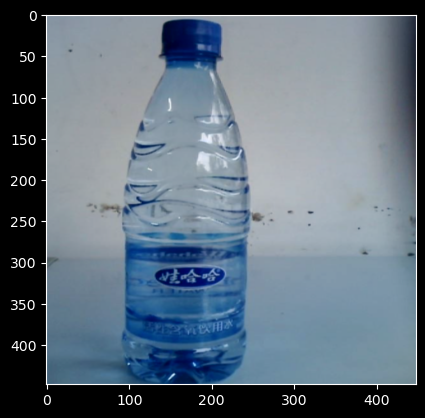

label: 13
idx:  13
预测标签名称:  今麦郎


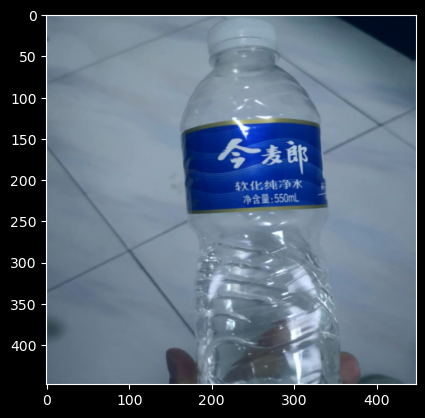

label: 1
idx:  5
预测标签名称:  其它


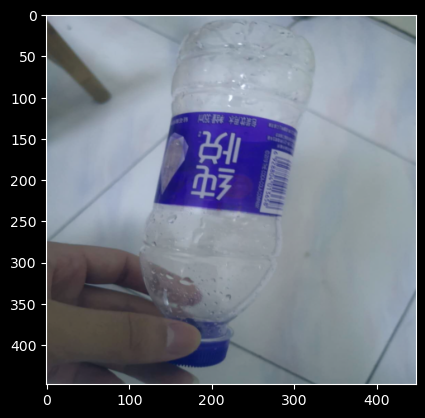

label: 5
idx:  9
预测标签名称:  百岁山


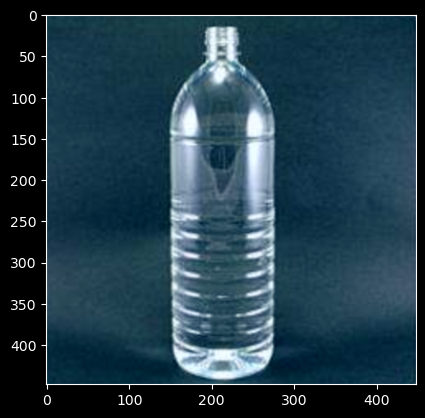

label: 0
idx:  0
预测标签名称:  农夫山泉


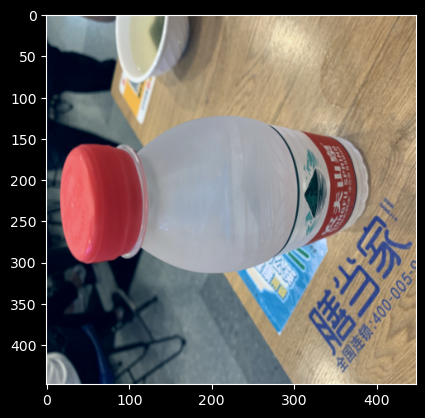

label: 9
idx:  9
预测标签名称:  百岁山


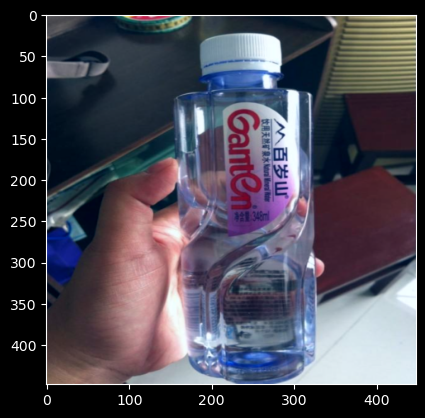

label: 10
idx:  10
预测标签名称:  苏打水


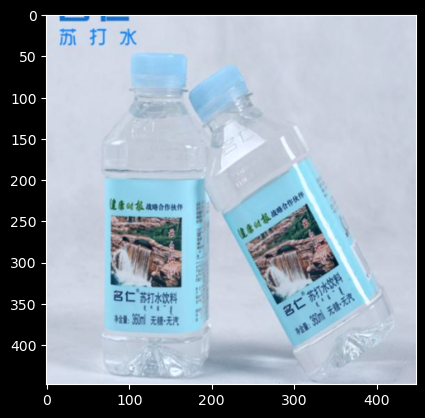

label: 4
idx:  4
预测标签名称:  天府可乐


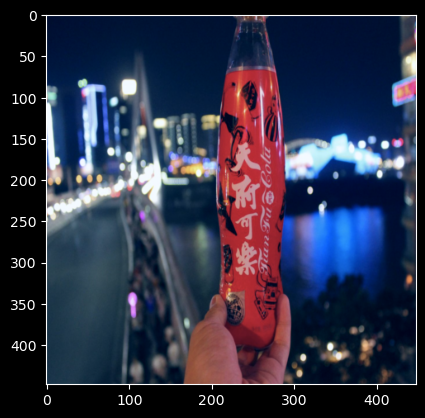

label: 0
idx:  0
预测标签名称:  农夫山泉


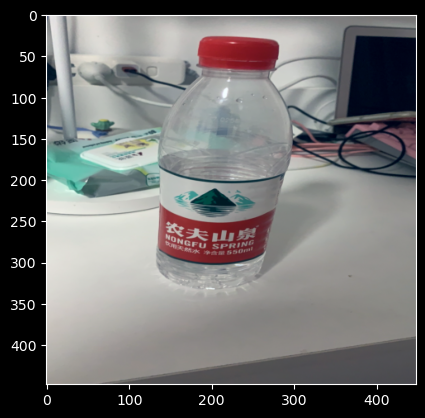

label: 8
idx:  8
预测标签名称:  怡宝


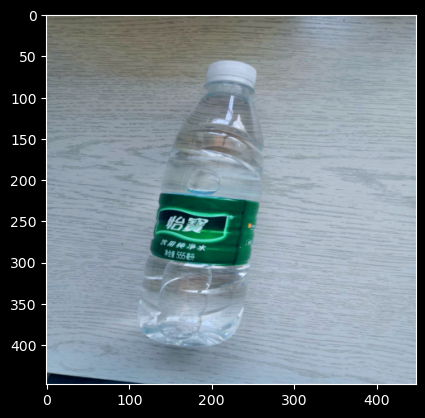

label: 2
idx:  2
预测标签名称:  娃哈哈


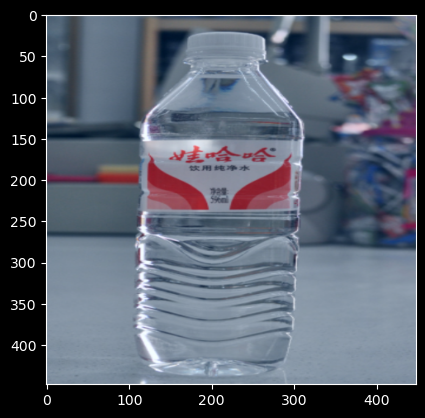

label: 4
idx:  4
预测标签名称:  天府可乐


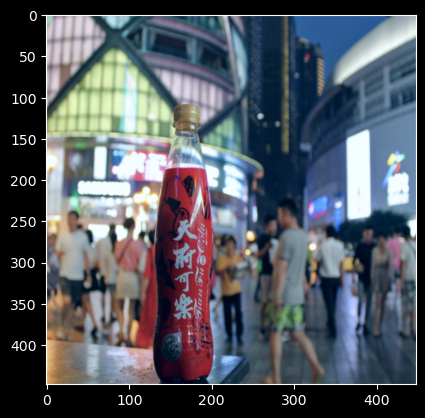

label: 4
idx:  4
预测标签名称:  天府可乐


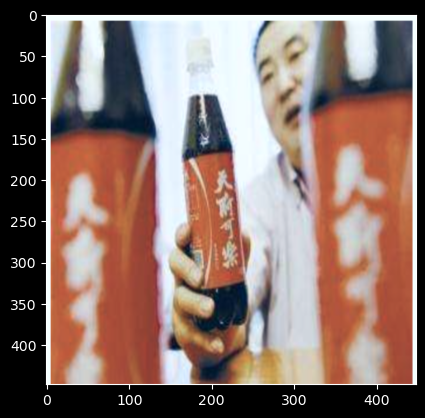

label: 5
idx:  2
预测标签名称:  娃哈哈


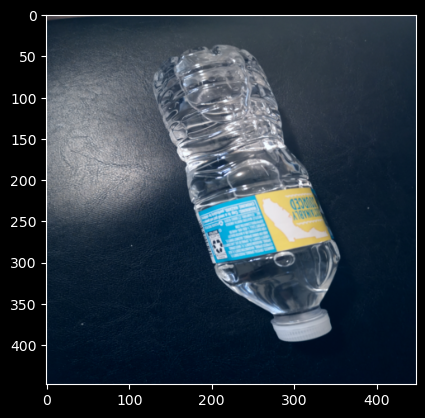

label: 2
idx:  2
预测标签名称:  娃哈哈


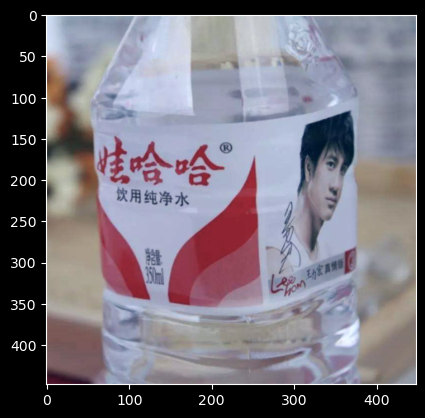

label: 5
idx:  4
预测标签名称:  天府可乐


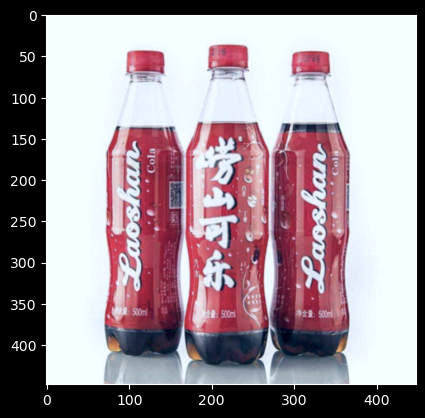

In [54]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

i = 0
normMean = [0.557, 0.517, 0.496]
normStd = [0.210, 0.216, 0.222]
normMean.reverse()
normStd.reverse()

for img, label in test_loader:
    images = img.to(device)
    labels = label.to(device)
    print('label:', labels.item())
    output = my_resnet(images)
    # print('output:', output.data.size)
    _, idx = torch.max(output.data, 1) # Output the location of the maximum value
    print('idx: ', idx.item())
    print('预测标签名称: ', idx_label[str(idx.item())])
    img = img[0, :, :, :].numpy()
    img = np.transpose(img, (1, 2, 0))

    img[:, :, 0] = img[:, :, 0]*normStd[0] + normMean[0]
    img[:, :, 1] = img[:, :, 1]*normStd[1] + normMean[1]
    img[:, :, 2] = img[:, :, 2]*normStd[2] + normMean[2]

    img = np.clip(img, 0, 1)

    plt.ion()
    plt.imshow((img))
    plt.pause(5)
    plt.close()
    i += 1
    # print(img)
    if i == 30:
        break
plt.show()
    